## Import Libraries and Load Data

In [ ]:
from collections import defaultdict
from copy import deepcopy
from datetime import datetime
import gzip
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time

import torch
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from typing import Dict, Any, Tuple
import warnings

warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

PyTorch version: 2.8.0+cu128
CUDA available: True


In [2]:
DATA_FILE = '../data/dataset0.json.gz'
LABELS_FILE = '../data/data.info.labelled'

def load_data(data_file, labels_file):
    """Load dataset"""
    print("Loading dataset...")
    rows = []
    
    with gzip.open(data_file, 'rt', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)
    
    with gzip.open(data_file, 'rt', encoding='utf-8') as f:
        for line in tqdm(f, total=total_lines, desc="Loading data"):
            data = json.loads(line)
            for transcript_id, positions in data.items():
                for transcript_position, sequences in positions.items():
                    for sequence, feature_list in sequences.items():
                        for features in feature_list:
                            rows.append({
                                'transcript_id': transcript_id,
                                'transcript_position': int(transcript_position),
                                'sequence': sequence,
                                'dwell_-1': features[0],
                                'std_-1': features[1],
                                'mean_-1': features[2],
                                'dwell_0': features[3],
                                'std_0': features[4],
                                'mean_0': features[5],
                                'dwell_+1': features[6],
                                'std_+1': features[7],
                                'mean_+1': features[8],
                            })
    
    df = pd.DataFrame(rows)
    labels = pd.read_csv(labels_file)
    df = pd.merge(df, labels, on=['transcript_id', 'transcript_position'], how='left')

    # --- Derived features requested by user ---
    # Add neighbor-difference features that capture local changes across positions -1, 0, +1
    # 1) mean shifts
    df['mean_0_minus_mean_-1'] = df['mean_0'] - df['mean_-1']
    df['mean_0_minus_mean_+1'] = df['mean_0'] - df['mean_+1']
    # 2) dwell shifts
    df['dwell_0_minus_dwell_-1'] = df['dwell_0'] - df['dwell_-1']
    df['dwell_0_minus_dwell_+1'] = df['dwell_0'] - df['dwell_+1']
    # 3) relative std: std_0 minus average of neighbor stds
    df['std_0_minus_avg_neighbor_std'] = df['std_0'] - ((df['std_-1'] + df['std_+1']) / 2.0)
    
    cols = ['gene_id', 'label'] + [col for col in df.columns if col not in ['gene_id', 'label']]
    df = df[cols]
    
    print(f"Loaded {len(df)} reads from {len(df.groupby(['transcript_id', 'transcript_position']))} sites")
    return df, labels

# Load data
df, labels = load_data(DATA_FILE, LABELS_FILE)
print(f"\nData shape: {df.shape}")
print(f"Labels shape: {labels.shape}")
print(f"\nFirst few rows:")
df.head()

Loading dataset...


Loading data: 100%|██████████| 121838/121838 [00:42<00:00, 2838.05it/s]



Loaded 11027106 reads from 121838 sites

Data shape: (11027106, 19)
Labels shape: (121838, 4)

First few rows:

Data shape: (11027106, 19)
Labels shape: (121838, 4)

First few rows:


,gene_id,label,transcript_id,transcript_position,sequence,dwell_-1,std_-1,mean_-1,dwell_0,std_0,mean_0,dwell_+1,std_+1,mean_+1,mean_0_minus_mean_-1,mean_0_minus_mean_+1,dwell_0_minus_dwell_-1,dwell_0_minus_dwell_+1,std_0_minus_avg_neighbor_std
0,ENSG00000004059,0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1,-3.0,37.9,0.01471,0.00840,3.920
1,ENSG00000004059,0,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9,1.0,45.1,0.00213,-0.00186,0.255
2,ENSG00000004059,0,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6,15.0,44.4,0.00895,0.00862,8.975
3,ENSG00000004059,0,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4,5.0,49.6,0.00432,0.00332,2.090
4,ENSG00000004059,0,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2,9.0,46.8,-0.00398,-0.01034,-1.095


## Data Preprocessing

In [3]:
BASE2IDX = {'A':0, 'C':1, 'G':2, 'T':3, 'U':3}
PAD_IDX = 4

def seq_to_idx7(s: str):
    s = str(s).upper().replace('U', 'T')
    return np.array([BASE2IDX.get(ch, 0) for ch in s], dtype=np.int64)

site_key = ['transcript_id', 'transcript_position']
num_cols = [
    'dwell_-1','std_-1','mean_-1',
    'dwell_0','std_0','mean_0',
    'dwell_+1','std_+1','mean_+1',
    # derived features (differences and local std contrast)
    'mean_0_minus_mean_-1',
    'mean_0_minus_mean_+1',
    'dwell_0_minus_dwell_-1',
    'dwell_0_minus_dwell_+1',
    'std_0_minus_avg_neighbor_std'
]
seq_col = 'sequence'  
label_col = 'label'

def split_by_gene(df, test_size=0.1, val_size=0.1, random_state=42):
    """Split data by gene_id to avoid data leakage"""
    unique_genes = df['gene_id'].unique()
    
    train_val_genes, test_genes = train_test_split(
        unique_genes, 
        test_size=test_size, 
        random_state=random_state
    )
    
    train_genes, val_genes = train_test_split(
        train_val_genes, 
        test_size=val_size/(1-test_size),
        random_state=random_state
    )
    
    train_df = df[df['gene_id'].isin(train_genes)].copy()
    val_df = df[df['gene_id'].isin(val_genes)].copy()
    test_df = df[df['gene_id'].isin(test_genes)].copy()
    
    print(f"Train genes: {len(train_genes)}, Val genes: {len(val_genes)}, Test genes: {len(test_genes)}")
    print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")
    
    return train_df, val_df, test_df

def scale_features(train_df, val_df, test_df, num_cols):
    """Scale numeric features using StandardScaler fit on training data only"""
    data_scaler = StandardScaler()
    
    train_df[num_cols] = data_scaler.fit_transform(train_df[num_cols])
    val_df[num_cols] = data_scaler.transform(val_df[num_cols])
    test_df[num_cols] = data_scaler.transform(test_df[num_cols])
    
    return train_df, val_df, test_df, data_scaler

def create_bags(df, site_key, num_cols, seq_col, label_col, min_reads=1, max_reads=50):
    bags = []
    grouped = df.groupby(site_key)

    for site, group in grouped:
        if len(group) < min_reads:
            continue

        features = group[num_cols].to_numpy(dtype=np.float32)
        sequences = group[seq_col].astype(str).tolist()
        seq_idx = np.vstack([seq_to_idx7(s) for s in sequences])

        labels = group[label_col].to_numpy()
        site_label = int(labels[0])

        if len(features) > max_reads:
            idx = np.random.choice(len(features), max_reads, replace=False)
            features = features[idx]
            seq_idx  = seq_idx[idx]

        bags.append({
            'site': site,
            'transcript_id': site[0],
            'transcript_position': int(site[1]),
            'features': features,
            'seq_idx': seq_idx,
            'n_reads': len(features),
            'label': site_label,
            'gene_id': group['gene_id'].iloc[0],
        })

    print(f"Created {len(bags)} bags from {len(grouped)} sites")
    return bags

def preprocess_data(df):
    """Complete preprocessing pipeline"""
    train_df, val_df, test_df = split_by_gene(df)
    train_df, val_df, test_df, scaler = scale_features(train_df, val_df, test_df, num_cols)
    
    train_bags = create_bags(train_df, site_key, num_cols, seq_col, label_col)
    val_bags = create_bags(val_df, site_key, num_cols, seq_col, label_col)
    test_bags = create_bags(test_df, site_key, num_cols, seq_col, label_col)
    
    print("\nBag statistics:")
    for name, bags in [("Train", train_bags), ("Val", val_bags), ("Test", test_bags)]:
        n_positive = sum(1 for bag in bags if bag['label'] == 1)
        avg_reads = np.mean([bag['n_reads'] for bag in bags])
        print(f"{name}: {len(bags)} bags, {n_positive} positive ({n_positive/len(bags)*100:.1f}%), "
              f"avg {avg_reads:.1f} reads/bag")
    
    return train_bags, val_bags, test_bags, scaler


class RNA_MIL_Dataset(Dataset):
    """
    Dataset with positive bag oversampling support.
    Yields: x_num [B, bag_size, F], x_seq [B, bag_size, L], mask [B, bag_size], y [B]
    """
    def __init__(self, bags, bag_size=40, is_train=True, pad_idx=PAD_IDX, oversample_positive=False, oversample_factor=3):
        self.bags = bags
        self.bag_size = bag_size
        self.is_train = is_train
        self.pad_idx = pad_idx

        if is_train and oversample_positive:
            pos_bags = [b for b in bags if b['label'] == 1]
            neg_bags = [b for b in bags if b['label'] == 0]
            print(f"Original: {len(pos_bags)} positive, {len(neg_bags)} negative bags")
            self.bags = neg_bags + pos_bags * oversample_factor
            print(f"After oversampling ({oversample_factor}x): {len(self.bags)} total bags")

        self.proc = []
        self.labels = []

        for bag in self.bags:
            num = bag['features']
            seq = bag['seq_idx']
            n = bag['n_reads']
            if n == 0:
                continue

            if n < bag_size:
                pad_num = np.zeros((bag_size - n, num.shape[1]), dtype=np.float32)
                pad_seq = np.full((bag_size - n, seq.shape[1]), self.pad_idx, dtype=np.int64)
                num_fixed = np.vstack([num, pad_num])
                seq_fixed = np.vstack([seq, pad_seq])
                mask = np.zeros(bag_size, dtype=np.float32)
                mask[:n] = 1.0
            else:
                if n > bag_size:
                    if self.is_train:
                        # keep stochastic sampling for training
                        idx = np.random.choice(n, bag_size, replace=False)
                    else:
                        # deterministic pseudo-random sampling for val/test:
                        # seed derived from transcript_id and position so it's repeatable
                        # bag here is the same `bag` dict in the loop (has 'transcript_id' and 'transcript_position')
                        seed = (hash(f"{bag['transcript_id']}:{bag['transcript_position']}") & 0xffffffff)
                        rng = np.random.default_rng(seed)
                        idx = rng.choice(n, bag_size, replace=False)
                else:
                    idx = np.arange(bag_size)
            num_fixed = num[idx].astype(np.float32)
            seq_fixed = seq[idx].astype(np.int64)
            mask = np.ones(bag_size, dtype=np.float32)

            self.proc.append({
                'num': num_fixed,
                'seq': seq_fixed,
                'mask': mask,
                'transcript_id': bag['transcript_id'],
                'position': bag['transcript_position'],
                'n_original_reads': n
            })
            self.labels.append(float(bag['label']))

    def __len__(self):
        return len(self.proc)

    def __getitem__(self, idx):
        b = self.proc[idx]
        x_num = torch.from_numpy(b['num'])
        x_seq = torch.from_numpy(b['seq'])
        mask  = torch.from_numpy(b['mask'])
        y     = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x_num, x_seq, mask, y

    def get_metadata(self, idx):
        b = self.proc[idx]
        return {
            'transcript_id': b['transcript_id'],
            'position': b['position'],
            'n_original_reads': b['n_original_reads'],
            'label': self.labels[idx]
        }


def create_dataloaders(train_bags, val_bags, test_bags, batch_size=32, bag_size=20, oversample_positive=False, oversample_factor=3):
    train_ds = RNA_MIL_Dataset(train_bags, bag_size=bag_size, is_train=True,  pad_idx=PAD_IDX, 
                               oversample_positive=oversample_positive, oversample_factor=oversample_factor)
    val_ds   = RNA_MIL_Dataset(val_bags,   bag_size=bag_size, is_train=False, pad_idx=PAD_IDX)
    test_ds  = RNA_MIL_Dataset(test_bags,  bag_size=bag_size, is_train=False, pad_idx=PAD_IDX)

    common = dict(num_workers=0, pin_memory=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  **common)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, **common)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, **common)
    return train_loader, val_loader, test_loader


def prepare_data(df, train_bags=None, val_bags=None, test_bags=None, scaler=None, batch_size=32, bag_size=20):
    """Complete data preparation pipeline"""
    train_loader, val_loader, test_loader = create_dataloaders(
        train_bags, val_bags, test_bags, 
        batch_size=batch_size, 
        bag_size=bag_size
    )
    
    print(f"\nDataLoader info:")
    print(f"Train: {len(train_loader)} batches")
    print(f"Val: {len(val_loader)} batches")
    print(f"Test: {len(test_loader)} batches")
    return train_loader, val_loader, test_loader, scaler

train_bags, val_bags, test_bags, scaler = preprocess_data(df)

train_loader, val_loader, test_loader = create_dataloaders(
    train_bags, val_bags, test_bags, 
    batch_size=32, 
    bag_size=20, 
    oversample_positive=False,
    oversample_factor=3,
)

Train genes: 3080, Val genes: 386, Test genes: 386
Train samples: 8808283, Val samples: 1131040, Test samples: 1087783
Created 97103 bags from 97103 sites
Created 97103 bags from 97103 sites
Created 11975 bags from 11975 sites
Created 11975 bags from 11975 sites
Created 12760 bags from 12760 sites

Bag statistics:
Train: 97103 bags, 4415 positive (4.5%), avg 41.1 reads/bag
Val: 11975 bags, 470 positive (3.9%), avg 41.0 reads/bag
Test: 12760 bags, 590 positive (4.6%), avg 41.0 reads/bag
Created 12760 bags from 12760 sites

Bag statistics:
Train: 97103 bags, 4415 positive (4.5%), avg 41.1 reads/bag
Val: 11975 bags, 470 positive (3.9%), avg 41.0 reads/bag
Test: 12760 bags, 590 positive (4.6%), avg 41.0 reads/bag


## Model Architecture

In [4]:
class SeqEmbCNN(nn.Module):
    def __init__(self, vocab=5, d_emb=8, kernel_sizes=(2,3,4,5), n_filters=32, d_out=64):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_emb, padding_idx=PAD_IDX)
        self.convs = nn.ModuleList([
            nn.Conv1d(d_emb, n_filters, ks, padding=0) for ks in kernel_sizes
        ])
        # Learned attention pooling per-conv (scores over sequence positions)
        self.attentions = nn.ModuleList([
            nn.Linear(n_filters, 1) for _ in kernel_sizes
        ])
        self.proj = nn.Linear(n_filters * len(kernel_sizes), d_out)
        self.norm = nn.LayerNorm(d_out)
    
    def forward(self, x_idx):
        # x_idx: [B, L]
        X = self.emb(x_idx).transpose(1,2)  # [B, d_emb, L]
        feats = []
        for conv, att in zip(self.convs, self.attentions):
            h = torch.nn.functional.gelu(conv(X))              # [B, n_filters, L]
            # attention pooling over positions
            h_t = h.permute(0, 2, 1)         # [B, L, n_filters]
            scores = att(h_t).squeeze(-1)   # [B, L]
            weights = torch.nn.functional.softmax(scores, dim=1).unsqueeze(-1)  # [B, L, 1]
            pooled = (h_t * weights).sum(dim=1)               # [B, n_filters]
            feats.append(pooled)
        z = torch.cat(feats, dim=1)
        z = self.proj(z)
        return self.norm(torch.nn.functional.gelu(z))


class GatedAttentionPooling(nn.Module):
    """Gated attention mechanism that can explicitly suppress noisy instances"""
    def __init__(self, d_model, n_heads=4, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.Tanh(),
                nn.Dropout(dropout),
                nn.Linear(d_model, 1)
            ) for _ in range(n_heads)
        ])
        
        # Gating mechanism to suppress noisy instances
        self.gate = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
            nn.Sigmoid()
        )
        
        self.fusion = nn.Sequential(
            nn.Linear(d_model * n_heads, d_model),
            nn.LayerNorm(d_model),
            nn.GELU()
        )
    
    def forward(self, h, mask):
        """
        Args:
            h: [B, K, d_model] - instance representations
            mask: [B, K] - mask for valid instances
        Returns:
            bag_repr: [B, d_model] - aggregated bag representation
            avg_weights: [B, K] - attention weights
            gates: [B, K] - confidence scores for each instance
        """
        # Compute gates (confidence scores for each instance)
        gates = self.gate(h).squeeze(-1) * mask  # [B, K]
        
        pooled = []
        all_weights = []
        
        for attn in self.attention_heads:
            scores = attn(h).squeeze(-1)  # [B, K]
            
            # Apply gating to attention scores
            gated_scores = scores * gates
            gated_scores = gated_scores.masked_fill(mask == 0, float('-inf'))
            
            weights = torch.nn.functional.softmax(gated_scores, dim=1).unsqueeze(-1)  # [B, K, 1]
            pooled.append((h * weights).sum(dim=1))  # [B, d_model]
            all_weights.append(weights.squeeze(-1))
        
        bag_repr = self.fusion(torch.cat(pooled, dim=-1))
        avg_weights = torch.stack(all_weights, dim=0).mean(dim=0)
        
        return bag_repr, avg_weights, gates


class TransformerMIL(nn.Module):
    """Transformer-based Multiple Instance Learning with noise handling"""
    
    def __init__(self, 
                 num_features=9,
                 d_model=128,
                 n_heads=4,
                 n_layers=4,
                 d_ff=1024,
                 dropout=0.1,
                 attn_pool_heads=4,
                 instance_dropout=0.15):
        super().__init__()
        
        self.instance_dropout = instance_dropout
        
        self.seq_encoder = SeqEmbCNN(vocab=5, d_emb=8, kernel_sizes=(2,3,4,5), n_filters=32, d_out=64)
        
        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.feature_fusion = nn.Sequential(
            nn.Linear(128, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Use gated attention instead of simple attention
        self.attention_pool = GatedAttentionPooling(d_model, n_heads=attn_pool_heads, dropout=dropout)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model // 4),
            nn.LayerNorm(d_model // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 4, 1)
        )
        
        # Stronger instance classifier for MIL
        self.instance_classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 4, 1)
        )
    
    def encode_sequences(self, x_seq):
        """Encode sequence data using CNN"""
        B, K, L = x_seq.shape
        seq_flat = x_seq.reshape(B * K, L)
        z_seq = self.seq_encoder(seq_flat)
        return z_seq.view(B, K, -1)
    
    def apply_instance_dropout(self, mask):
        """Randomly drop instances during training to improve robustness to noise"""
        if not self.training or self.instance_dropout == 0:
            return mask
        
        B, K = mask.shape
        dropout_mask = torch.rand(B, K, device=mask.device) > self.instance_dropout
        
        # Ensure at least 5 instances remain per bag
        n_keep = (dropout_mask * mask).sum(dim=1, keepdim=True)
        too_few = n_keep < 5
        dropout_mask = torch.where(too_few, torch.ones_like(dropout_mask), dropout_mask)
        
        return mask * dropout_mask.float()
    
    def forward(self, x_num, mask, x_seq=None):
        """
        Args:
            x_num: Numeric features [B, K, num_features]
            mask: Mask for padding [B, K]
            x_seq: Sequence indices [B, K, L]
        Returns:
            bag_logits, attention_weights, instance_logits, gates
        """
        B, K, _ = x_num.shape
        
        # Apply instance dropout during training
        effective_mask = self.apply_instance_dropout(mask)
        
        num_features = self.num_proj(x_num)
        
        if x_seq is not None:
            seq_features = self.encode_sequences(x_seq)
            combined = torch.cat([num_features, seq_features], dim=-1)
        else:
            combined = num_features
        
        h = self.feature_fusion(combined)
        
        src_key_padding_mask = (effective_mask == 0)
        h = self.transformer(h, src_key_padding_mask=src_key_padding_mask)
        
        # Return LOGITS instead of probabilities for instance predictions
        instance_logits = self.instance_classifier(h).squeeze(-1)
        # Mask out padding with -inf so they don't affect max/logsumexp
        instance_logits = instance_logits.masked_fill(effective_mask == 0, float('-inf'))
        
        bag_repr, attention_weights, gates = self.attention_pool(h, effective_mask)
        bag_logits = self.classifier(bag_repr).squeeze(-1)
        
        return bag_logits, attention_weights, instance_logits, gates

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.1, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probs = torch.sigmoid(logits)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        alpha_weight = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = alpha_weight * focal_weight * bce_loss
        return loss.mean()


class MILLoss(nn.Module):
    """Majority-based MIL: align bag label with the fraction of positive instances"""
    def __init__(self, alpha=1.0, beta=1.0, focal_gamma=3.0, class_weight=None, tau=0.5):
        super().__init__()
        # alpha: weight for proportion (majority) loss
        # beta: weight for negative-bag instance suppression
        self.alpha = alpha
        self.beta = beta
        self.focal = FocalLoss(gamma=focal_gamma)
        self.class_weight = class_weight
        self.tau = tau  # majority threshold used for evaluation; training uses BCE at 0.5 implicitly
        
    def forward(self, bag_logits, instance_logits, labels, mask):
        # 1) Bag-level supervised loss (keeps bag classifier trained)
        if self.class_weight is not None:
            weights = torch.where(labels == 1, self.class_weight[1], self.class_weight[0])
            bce_loss = F.binary_cross_entropy_with_logits(bag_logits, labels, reduction='none')
            bag_loss = (bce_loss * weights).mean()
        else:
            bag_loss = self.focal(bag_logits, labels)
        
        # 2) Proportion-based bag loss (majority MIL)
        # Compute masked instance probabilities
        # Replace -inf (from masked logits) with a large negative, then sigmoid -> 0
        safe_instance_logits = instance_logits.clone()
        safe_instance_logits[~torch.isfinite(safe_instance_logits)] = -30.0
        inst_probs = torch.sigmoid(safe_instance_logits) * mask
        valid_counts = mask.sum(dim=1).clamp_min(1)
        prop = inst_probs.sum(dim=1) / valid_counts
        prop = torch.clamp(prop, 1e-7, 1 - 1e-7)
        prop_logits = torch.log(prop / (1 - prop))
        prop_loss = F.binary_cross_entropy_with_logits(prop_logits, labels)
        
        # 3) Negative-bag instance suppression (keep simple average prob low)
        neg_mask = (labels == 0).float().unsqueeze(1)  # [B,1]
        neg_inst_penalty = (inst_probs.sum(dim=1) / valid_counts)  # [B]
        neg_inst_penalty = (neg_inst_penalty * neg_mask.squeeze(1)).sum() / (neg_mask.sum() + 1e-6)
        
        total_loss = bag_loss + self.alpha * prop_loss + self.beta * neg_inst_penalty
        
        # For logging: we can report prop_loss as mil_loss_pos and neg_inst_penalty as mil_loss_neg
        mil_loss_pos = prop_loss.detach()
        mil_loss_neg = neg_inst_penalty.detach()
        return total_loss, bag_loss, mil_loss_pos, mil_loss_neg

model = TransformerMIL(
    num_features=len(num_cols),
    d_model=128,
    n_heads=4,
    n_layers=4,
    d_ff=1024,
    dropout=0.1,
    attn_pool_heads=4,
    instance_dropout=0.15
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
print(f"\nModel architecture:")
print(f"  d_model: 128")
print(f"  n_layers: 4")
print(f"  n_heads: 4")
print(f"  d_ff: 1024")
print(f"  dropout: 0.1")
print(f"  attention pooling heads: 4")
print(f"  instance dropout: 0.15")
print(f"\nTraining objective:")
print(f"  ✓ Bag BCE on bag_logits")
print(f"  ✓ Proportion loss (masked mean of instance probs) -> BCE on logit(mean)")
print(f"  ✓ Negative-bag instance suppression")

Total parameters: 1,528,179

Model architecture:
  d_model: 128
  n_layers: 4
  n_heads: 4
  d_ff: 1024
  dropout: 0.1
  attention pooling heads: 4
  instance dropout: 0.15

Training objective:
  ✓ Bag BCE on bag_logits
  ✓ Proportion loss (masked mean of instance probs) -> BCE on logit(mean)
  ✓ Negative-bag instance suppression


## Training and Evaluation

In [ ]:
LEARNING_RATE = 0.00013109833200274283
WEIGHT_DECAY = 1e-5
EPOCHS = 50
PATIENCE = 10
MIXED_PRECISION = True
WARMUP_STEPS = 1000  # Learning rate warmup steps

TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
RUN_DIR = f'../models'
OUTPUT_DIR = f'{RUN_DIR}'
CHECKPOINT_DIR = f'{RUN_DIR}'

print(f"Training run timestamp: {TIMESTAMP}")
print(f"Run directory: {RUN_DIR}")
print(f"  - Outputs: {OUTPUT_DIR}")
print(f"  - Checkpoints: {CHECKPOINT_DIR}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel: Transformer MIL")
print(f"Total trainable parameters: {total_params:,}")

n_positive = sum(1 for bag in train_bags if bag['label'] == 1)
n_negative = len(train_bags) - n_positive
pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

print(f"\nClass distribution:")
print(f"  Positive bags: {n_positive} ({n_positive/len(train_bags)*100:.2f}%)")
print(f"  Negative bags: {n_negative} ({n_negative/len(train_bags)*100:.2f}%)")
print(f"  Positive weight (inverse frequency): {pos_weight:.2f}")

class_weights = torch.tensor([1.0, pos_weight], dtype=torch.float32).to(device)

optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate warmup scheduler
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer, 
    lambda step: min(1.0, (step + 1) / WARMUP_STEPS)
)

amp_scaler = GradScaler() if MIXED_PRECISION else None

# Save feature scaler (StandardScaler) and AMP GradScaler state to the checkpoint directory
save_dir = Path(CHECKPOINT_DIR)
save_dir.mkdir(parents=True, exist_ok=True)
# Feature scaler returned earlier by preprocess_data is stored in variable `scaler`
if 'scaler' in globals() and scaler is not None:
    try:
        scaler_path = save_dir / 'scaler.joblib'
        joblib.dump(scaler, scaler_path)
        print(f'Saved feature StandardScaler to {scaler_path}')
    except Exception as e:
        print('Could not save feature scaler:', e)
else:
    print('Feature scaler not found in globals; skipping saving feature scaler.')

# Save AMP GradScaler state so training can resume with same AMP state if desired
if amp_scaler is not None:
    try:
        amp_path = save_dir / 'amp_grad_scaler.pt'
        torch.save(amp_scaler.state_dict(), amp_path)
        print(f'Saved AMP GradScaler state to {amp_path}')
    except Exception as e:
        print('Could not save AMP GradScaler state:', e)

print(f"\nTraining configuration:")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"  Learning rate warmup: {WARMUP_STEPS} steps")
print(f"  Mixed precision: {MIXED_PRECISION}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  Class weights: [1.0, {pos_weight:.2f}]")

Training run timestamp: 20251029_105547
Run directory: ../runs/run_20251029_105547
  - Outputs: ../runs/run_20251029_105547/outputs
  - Checkpoints: ../runs/run_20251029_105547/checkpoints

Using device: cuda

Model: Transformer MIL
Total trainable parameters: 1,528,179

Class distribution:
  Positive bags: 4415 (4.55%)
  Negative bags: 92688 (95.45%)
  Positive weight (inverse frequency): 20.99

Model: Transformer MIL
Total trainable parameters: 1,528,179

Class distribution:
  Positive bags: 4415 (4.55%)
  Negative bags: 92688 (95.45%)
  Positive weight (inverse frequency): 20.99
Saved feature StandardScaler to ..\runs\run_20251029_105547\checkpoints\scaler.joblib
Saved AMP GradScaler state to ..\runs\run_20251029_105547\checkpoints\amp_grad_scaler.pt

Training configuration:
  Optimizer: AdamW (lr=0.00013109833200274283, weight_decay=1e-05)
  Learning rate warmup: 1000 steps
  Mixed precision: True
  Early stopping patience: 10
  Class weights: [1.0, 20.99]
Saved feature StandardSca

In [6]:
# Show a quick sample batch structure for debugging
batch = next(iter(test_loader))
print(type(batch))
try:
    print(len(batch))
    print([type(x) for x in batch])
except Exception as e:
    print("Could not inspect batch as sequence:", e)
print("Batch repr (truncated):")
print(str(batch)[:500])

<class 'list'>
4
[<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]
Batch repr (truncated):
[tensor([[[ 1.2344, -0.9814,  0.0921,  ...,  0.7488,  1.6483, -0.4016],
         [ 1.3820,  0.2979,  0.2599,  ..., -1.5668, -0.6325, -0.9800],
         [-1.0691, -1.1442, -0.0758,  ...,  1.2874,  0.9941, -0.3860],
         ...,
         [ 0.7176,  0.0731,  0.1760,  ...,  0.2471,  1.1140, -0.7237],
         [ 0.9022, -0.5743,  0.0921,  ..., -0.4922, -0.0582, -0.1625],
         [-1.0691, -0.6674,  0.0082,  ...,  0.4887, -0.0508, -0.7158]],

        [[-0.2717, -0.4968,  0.6794,  ...,  0.1719,  0.23


In [ ]:
# Training loop utility: run_training
# Inserts a standard train/val/test loop compatible with the notebook's model and MILLoss.

def safe_metrics(y_true, y_prob):
    """Compute ROC and PR safely (return np.nan when not computable)."""
    try:
        roc = roc_auc_score(y_true, y_prob)
    except Exception:
        roc = float('nan')
    try:
        pr = average_precision_score(y_true, y_prob)
    except Exception:
        pr = float('nan')
    return roc, pr


def run_training(
    model,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    criterion,
    device,
    scaler=None,
    scheduler=None,
    epochs=20,
    patience=5,
    mixed_precision=True,
    ckpt_dir=None,
):
    """Train/validate/test loop.

    Returns a dict with keys: 'history' (list of per-epoch dicts),
    'test_metrics' (dict), and 'test_loss' (float).

    Notes:
    - Expects `criterion(bag_logits, inst_logits, labels, mask)` to return
      either a scalar loss or a tuple-like (total_loss, bag_loss, mil_pos, mil_neg).
    - Records training bag-level and MIL component losses so notebook plotting works.
    """
    best_metric = -float('inf')
    best_state = None
    history = []
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        # --- Train ---
        model.train()
        train_total_losses = []
        train_bag_losses = []
        train_mil_pos_losses = []
        train_mil_neg_losses = []
        train_ys = []
        train_probs = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Train", leave=False):
            # Flexible unpacking (dataset yields 4 or 5 items)
            if isinstance(batch, (list, tuple)):
                if len(batch) >= 4:
                    x_num, x_seq, mask, y = batch[:4]
                else:
                    raise ValueError(f"Unexpected batch length in train: {len(batch)}")
            else:
                raise ValueError(f"Unexpected batch type in train: {type(batch)}")

            x_num = x_num.to(device)
            x_seq = x_seq.to(device)
            mask = mask.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            if mixed_precision and scaler is not None:
                with autocast(enabled=True):
                    out = model(x_num=x_num, x_seq=x_seq, mask=mask)
                    bag_logits, _, inst_logits, _ = out
                    loss_out = criterion(bag_logits, inst_logits, y, mask)
                    total_loss = loss_out[0] if isinstance(loss_out, (list, tuple)) else loss_out
                    # extract components if present
                    bag_loss_batch = loss_out[1] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 1 else None
                    mil_pos_batch = loss_out[2] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 2 else None
                    mil_neg_batch = loss_out[3] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 3 else None
                scaler.scale(total_loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                out = model(x_num=x_num, x_seq=x_seq, mask=mask)
                bag_logits, _, inst_logits, _ = out
                loss_out = criterion(bag_logits, inst_logits, y, mask)
                total_loss = loss_out[0] if isinstance(loss_out, (list, tuple)) else loss_out
                bag_loss_batch = loss_out[1] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 1 else None
                mil_pos_batch = loss_out[2] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 2 else None
                mil_neg_batch = loss_out[3] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 3 else None
                total_loss.backward()
                optimizer.step()

            if scheduler is not None:
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers expect epoch-level step
                    pass

            train_total_losses.append(total_loss.item())
            # store component losses if present (convert to scalar)
            if bag_loss_batch is not None:
                train_bag_losses.append(bag_loss_batch.item() if isinstance(bag_loss_batch, torch.Tensor) else float(bag_loss_batch))
            if mil_pos_batch is not None:
                train_mil_pos_losses.append(mil_pos_batch.item() if isinstance(mil_pos_batch, torch.Tensor) else float(mil_pos_batch))
            if mil_neg_batch is not None:
                train_mil_neg_losses.append(mil_neg_batch.item() if isinstance(mil_neg_batch, torch.Tensor) else float(mil_neg_batch))

            # collect train probs/labels for epoch-level AUC
            with torch.no_grad():
                probs_batch = torch.sigmoid(bag_logits).detach().cpu().numpy().tolist()
            train_probs.extend(probs_batch)
            train_ys.extend(y.detach().cpu().numpy().tolist())

        # --- Validation ---
        model.eval()
        val_losses = []
        val_bag_losses = []
        val_mil_pos_losses = []
        val_mil_neg_losses = []
        ys = []
        probs = []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} - Val", leave=False):
                if isinstance(batch, (list, tuple)):
                    if len(batch) >= 4:
                        x_num, x_seq, mask, y = batch[:4]
                    else:
                        raise ValueError(f"Unexpected batch length in val: {len(batch)}")
                else:
                    raise ValueError(f"Unexpected batch type in val: {type(batch)}")

                x_num = x_num.to(device)
                x_seq = x_seq.to(device)
                mask = mask.to(device)
                y = y.to(device)

                if mixed_precision and scaler is not None:
                    with autocast(enabled=True):
                        out = model(x_num=x_num, x_seq=x_seq, mask=mask)
                        bag_logits, _, inst_logits, _ = out
                        loss_out = criterion(bag_logits, inst_logits, y, mask)
                        val_loss = loss_out[0] if isinstance(loss_out, (list, tuple)) else loss_out
                        bag_loss_v = loss_out[1] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 1 else None
                        mil_pos_v = loss_out[2] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 2 else None
                        mil_neg_v = loss_out[3] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 3 else None
                else:
                    out = model(x_num=x_num, x_seq=x_seq, mask=mask)
                    bag_logits, _, inst_logits, _ = out
                    loss_out = criterion(bag_logits, inst_logits, y, mask)
                    val_loss = loss_out[0] if isinstance(loss_out, (list, tuple)) else loss_out
                    bag_loss_v = loss_out[1] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 1 else None
                    mil_pos_v = loss_out[2] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 2 else None
                    mil_neg_v = loss_out[3] if isinstance(loss_out, (list, tuple)) and len(loss_out) > 3 else None

                val_losses.append(val_loss.item())
                if bag_loss_v is not None:
                    val_bag_losses.append(bag_loss_v.item() if isinstance(bag_loss_v, torch.Tensor) else float(bag_loss_v))
                if mil_pos_v is not None:
                    val_mil_pos_losses.append(mil_pos_v.item() if isinstance(mil_pos_v, torch.Tensor) else float(mil_pos_v))
                if mil_neg_v is not None:
                    val_mil_neg_losses.append(mil_neg_v.item() if isinstance(mil_neg_v, torch.Tensor) else float(mil_neg_v))

                prob = torch.sigmoid(bag_logits).detach().cpu().numpy()
                probs.extend(prob.tolist())
                ys.extend(y.detach().cpu().numpy().tolist())

        # Compute metrics
        try:
            val_roc, val_pr = safe_metrics(np.array(ys), np.array(probs))
        except Exception:
            val_roc, val_pr = float('nan'), float('nan')

        # compute train ROC for reporting
        try:
            train_roc, train_pr = safe_metrics(np.array(train_ys), np.array(train_probs))
        except Exception:
            train_roc, train_pr = float('nan'), float('nan')

        # Combined metric for early stopping (you can change weighting)
        combined = (0.5 * (val_roc if not np.isnan(val_roc) else 0.0)) + (0.5 * (val_pr if not np.isnan(val_pr) else 0.0))

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch}/{epochs} — train_loss: {np.mean(train_total_losses):.4f} — val_loss: {np.mean(val_losses):.4f} — val_roc: {val_roc:.4f} — val_pr: {val_pr:.4f} — time: {epoch_time:.1f}s")

        history.append({
            'epoch': epoch,
            'train_loss': float(np.mean(train_total_losses)),
            'train_bag_loss': float(np.mean(train_bag_losses)) if len(train_bag_losses) > 0 else float('nan'),
            'train_mil_pos_loss': float(np.mean(train_mil_pos_losses)) if len(train_mil_pos_losses) > 0 else float('nan'),
            'train_mil_neg_loss': float(np.mean(train_mil_neg_losses)) if len(train_mil_neg_losses) > 0 else float('nan'),
            'train_auc': float(train_roc),
            'val_loss': float(np.mean(val_losses)),
            'val_bag_loss': float(np.mean(val_bag_losses)) if len(val_bag_losses) > 0 else float('nan'),
            'val_mil_pos_loss': float(np.mean(val_mil_pos_losses)) if len(val_mil_pos_losses) > 0 else float('nan'),
            'val_mil_neg_loss': float(np.mean(val_mil_neg_losses)) if len(val_mil_neg_losses) > 0 else float('nan'),
            'val_roc_auc': float(val_roc),
            'val_pr_auc': float(val_pr),
            'combined_metric': float(combined),
        })

        # Early stopping / checkpointing
        if combined > best_metric or best_state is None:
            best_metric = combined
            best_state = {
                'model': {k: v.cpu().clone() for k, v in model.state_dict().items()},
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'history': list(history),
            }
            if ckpt_dir is not None:
                Path(ckpt_dir).mkdir(parents=True, exist_ok=True)
                torch.save(best_state['model'], Path(ckpt_dir) / 'best_model_state.pt')

        # Early stop condition
        if epoch - best_state['epoch'] >= patience:
            print(f"Early stopping triggered (no improvement in {patience} epochs)")
            break

    # Load best model weights
    if best_state is not None:
        model.load_state_dict(best_state['model'])

    # Final test evaluation
    model.eval()
    test_losses = []
    ys = []
    probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Final Test Eval", leave=False):
            if isinstance(batch, (list, tuple)):
                if len(batch) >= 4:
                    x_num, x_seq, mask, y = batch[:4]
                else:
                    raise ValueError(f"Unexpected batch length in test: {len(batch)}")
            else:
                raise ValueError(f"Unexpected batch type in test: {type(batch)}")

            x_num = x_num.to(device)
            x_seq = x_seq.to(device)
            mask = mask.to(device)
            y = y.to(device)

            out = model(x_num=x_num, x_seq=x_seq, mask=mask)
            bag_logits, _, inst_logits, _ = out
            loss_out = criterion(bag_logits, inst_logits, y, mask)
            test_loss = loss_out[0] if isinstance(loss_out, (list, tuple)) else loss_out
            test_losses.append(test_loss.item())

            probs.extend(torch.sigmoid(bag_logits).cpu().numpy().tolist())
            ys.extend(y.detach().cpu().numpy().tolist())

    test_roc, test_pr = safe_metrics(np.array(ys), np.array(probs))
    test_metrics = {'roc_auc': float(test_roc), 'pr_auc': float(test_pr)}

    total_time = time.time() - start_time
    print(f"Training finished in {total_time/60:.2f} minutes. Test ROC: {test_roc:.4f}, Test PR: {test_pr:.4f}")

    return {
        'history': history,
        'test_metrics': test_metrics,
        'test_loss': float(np.mean(test_losses)) if len(test_losses) > 0 else float('nan'),
    }


In [8]:
criterion = MILLoss(
    class_weight=class_weights
).to(device)

print("Loss configuration:")
print(f"  MIL alpha: 1.5 (was 0.3 - stronger instance-level supervision)")
print(f"  MIL beta: 0.2 (NEW - negative bag instance suppression)")
print(f"  Focal gamma: 2.0")
print(f"  Class weights: {class_weights.cpu().numpy()}")
print("\n" + "="*80)

results = run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    scaler=amp_scaler if MIXED_PRECISION else None,
    scheduler=scheduler,
    epochs=EPOCHS,
    patience=PATIENCE,
    mixed_precision=MIXED_PRECISION,
    ckpt_dir=CHECKPOINT_DIR,
)

Loss configuration:
  MIL alpha: 1.5 (was 0.3 - stronger instance-level supervision)
  MIL beta: 0.2 (NEW - negative bag instance suppression)
  Focal gamma: 2.0
  Class weights: [ 1.       20.993885]



Epoch 1/50 — train_loss: 1.2212 — val_loss: 0.8845 — val_roc: 0.8912 — val_pr: 0.4001 — time: 99.8s


Epoch 2/50 — train_loss: 0.9840 — val_loss: 0.8522 — val_roc: 0.8956 — val_pr: 0.4128 — time: 102.1s


Epoch 3/50 — train_loss: 0.9477 — val_loss: 0.8760 — val_roc: 0.8994 — val_pr: 0.4069 — time: 100.8s


Epoch 4/50 — train_loss: 0.9258 — val_loss: 0.8652 — val_roc: 0.9022 — val_pr: 0.4283 — time: 103.6s


Epoch 5/50 — train_loss: 0.9214 — val_loss: 0.9468 — val_roc: 0.8944 — val_pr: 0.4017 — time: 99.6s


Epoch 6/50 — train_loss: 0.9069 — val_loss: 0.8565 — val_roc: 0.8981 — val_pr: 0.4228 — time: 100.6s


Epoch 7/50 — train_loss: 0.9014 — val_loss: 0.8365 — val_roc: 0.8986 — val_pr: 0.4253 — time: 101.6s


Epoch 8/50 — train_loss: 0.8935 — val_loss: 0.8309 — val_roc: 0.9018 — val_pr: 0.4273 — time: 112.9s


Epoch 9/50 — train_loss: 0.8776 — val_loss: 0.8386 — val_roc: 0.8983 — val_pr: 0.4219 — time: 105.4s


Epoch 10/50 — train_loss: 0.8643 — val_loss: 0.8275 — val_roc: 0.9029 — val_pr: 0.4208 — time: 100.5s


Epoch 11/50 — train_loss: 0.8759 — val_loss: 0.8419 — val_roc: 0.8985 — val_pr: 0.4283 — time: 105.5s


Epoch 12/50 — train_loss: 0.8732 — val_loss: 0.8326 — val_roc: 0.9030 — val_pr: 0.4267 — time: 104.7s


Epoch 13/50 — train_loss: 0.8658 — val_loss: 0.8576 — val_roc: 0.8989 — val_pr: 0.4391 — time: 107.7s


Epoch 14/50 — train_loss: 0.8587 — val_loss: 0.8280 — val_roc: 0.9050 — val_pr: 0.4256 — time: 110.7s


Epoch 15/50 — train_loss: 0.8484 — val_loss: 0.8063 — val_roc: 0.9063 — val_pr: 0.4297 — time: 105.1s


Epoch 16/50 — train_loss: 0.8494 — val_loss: 0.8095 — val_roc: 0.9040 — val_pr: 0.4377 — time: 116.9s


Epoch 17/50 — train_loss: 0.8389 — val_loss: 0.8248 — val_roc: 0.9049 — val_pr: 0.4402 — time: 121.3s


Epoch 18/50 — train_loss: 0.8397 — val_loss: 0.8774 — val_roc: 0.9075 — val_pr: 0.4367 — time: 117.3s


Epoch 19/50 — train_loss: 0.8368 — val_loss: 0.8385 — val_roc: 0.9051 — val_pr: 0.4351 — time: 121.5s


Epoch 20/50 — train_loss: 0.8519 — val_loss: 0.8121 — val_roc: 0.9058 — val_pr: 0.4408 — time: 127.6s


Epoch 21/50 — train_loss: 0.8348 — val_loss: 0.8205 — val_roc: 0.9056 — val_pr: 0.4485 — time: 128.7s


Epoch 22/50 — train_loss: 0.8339 — val_loss: 0.8303 — val_roc: 0.9043 — val_pr: 0.4440 — time: 125.5s


Epoch 23/50 — train_loss: 0.8266 — val_loss: 0.8144 — val_roc: 0.9055 — val_pr: 0.4416 — time: 120.3s


Epoch 24/50 — train_loss: 0.8171 — val_loss: 0.8439 — val_roc: 0.9054 — val_pr: 0.4417 — time: 101.2s


Epoch 25/50 — train_loss: 0.8158 — val_loss: 0.8728 — val_roc: 0.9023 — val_pr: 0.4292 — time: 105.4s


Epoch 26/50 — train_loss: 0.8383 — val_loss: 0.8204 — val_roc: 0.9064 — val_pr: 0.4372 — time: 104.7s


Epoch 27/50 — train_loss: 0.8146 — val_loss: 0.8067 — val_roc: 0.9057 — val_pr: 0.4399 — time: 104.7s


Epoch 28/50 — train_loss: 0.8135 — val_loss: 0.8101 — val_roc: 0.9067 — val_pr: 0.4404 — time: 114.1s


Epoch 29/50 — train_loss: 0.8288 — val_loss: 0.7917 — val_roc: 0.9084 — val_pr: 0.4371 — time: 121.5s


Epoch 30/50 — train_loss: 0.8069 — val_loss: 0.8873 — val_roc: 0.9047 — val_pr: 0.4262 — time: 121.7s


Epoch 31/50 — train_loss: 0.8048 — val_loss: 0.8478 — val_roc: 0.9079 — val_pr: 0.4358 — time: 118.3s
Early stopping triggered (no improvement in 10 epochs)


Training finished in 57.29 minutes. Test ROC: 0.9043, Test PR: 0.4820


## Plot Training History

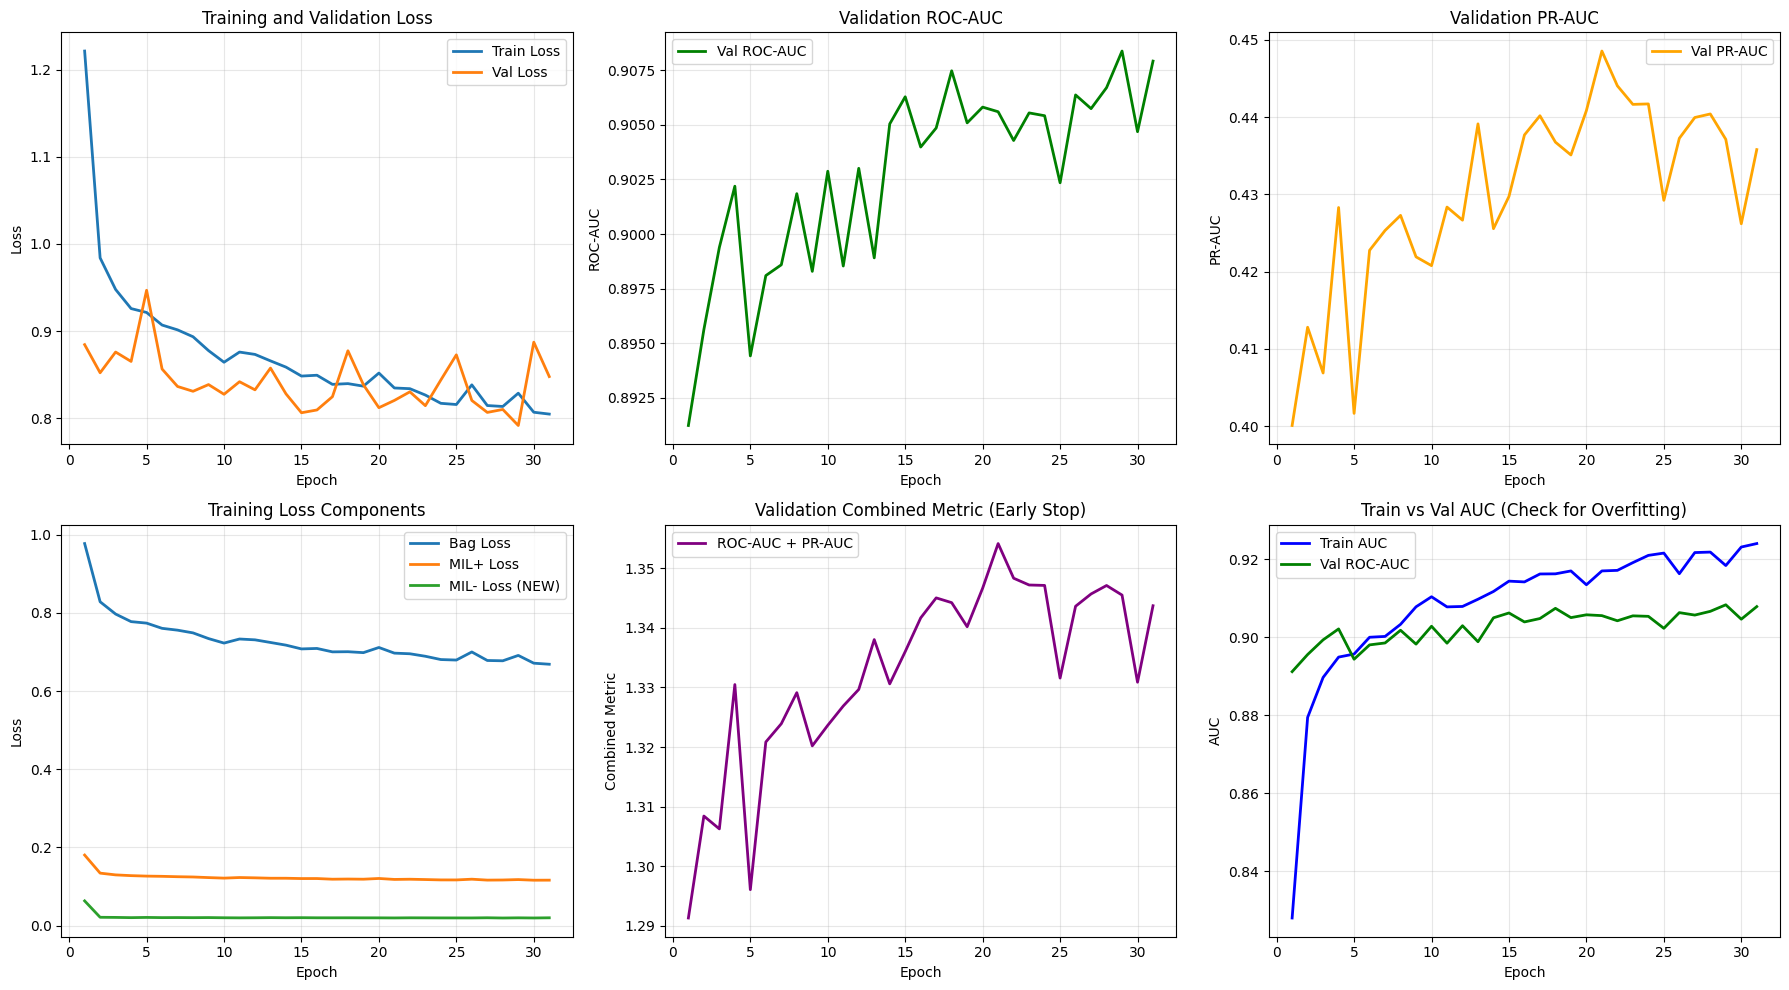


TRAINING ANALYSIS
Best epoch: 29
Best val ROC-AUC: 0.9084
Best val PR-AUC: 0.4485

Look for:
  ✓ Validation metrics should continue improving (not plateau early)
  ✓ MIL- loss should decrease (model learning to suppress negative instances)
  ✓ Gap between train/val AUC indicates overfitting level


In [9]:
# Extract history
history = results['history']
history_df = pd.DataFrame(history)

# Plot training curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Training and validation loss
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ROC-AUC
axes[0, 1].plot(history_df['epoch'], history_df['val_roc_auc'], label='Val ROC-AUC', linewidth=2, color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('ROC-AUC')
axes[0, 1].set_title('Validation ROC-AUC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# PR-AUC
axes[0, 2].plot(history_df['epoch'], history_df['val_pr_auc'], label='Val PR-AUC', linewidth=2, color='orange')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('PR-AUC')
axes[0, 2].set_title('Validation PR-AUC')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# MIL loss components (now includes negative bag loss)
axes[1, 0].plot(history_df['epoch'], history_df['train_bag_loss'], label='Bag Loss', linewidth=2)
axes[1, 0].plot(history_df['epoch'], history_df['train_mil_pos_loss'], label='MIL+ Loss', linewidth=2)
axes[1, 0].plot(history_df['epoch'], history_df['train_mil_neg_loss'], label='MIL- Loss (NEW)', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss Components')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Combined metric (early stopping criterion)
combined_metric = history_df['val_roc_auc'] + history_df['val_pr_auc']
axes[1, 1].plot(history_df['epoch'], combined_metric, label='ROC-AUC + PR-AUC', linewidth=2, color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Combined Metric')
axes[1, 1].set_title('Validation Combined Metric (Early Stop)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Training AUC
axes[1, 2].plot(history_df['epoch'], history_df['train_auc'], label='Train AUC', linewidth=2, color='blue')
axes[1, 2].plot(history_df['epoch'], history_df['val_roc_auc'], label='Val ROC-AUC', linewidth=2, color='green')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('AUC')
axes[1, 2].set_title('Train vs Val AUC (Check for Overfitting)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TRAINING ANALYSIS")
print("="*80)
print(f"Best epoch: {history_df.loc[history_df['val_roc_auc'].idxmax(), 'epoch']:.0f}")
print(f"Best val ROC-AUC: {history_df['val_roc_auc'].max():.4f}")
print(f"Best val PR-AUC: {history_df['val_pr_auc'].max():.4f}")
print(f"\nLook for:")
print("  ✓ Validation metrics should continue improving (not plateau early)")
print("  ✓ MIL- loss should decrease (model learning to suppress negative instances)")
print("  ✓ Gap between train/val AUC indicates overfitting level")
print("="*80)

In [10]:
# Small helper to pretty-print metric dicts used in the notebook
def format_metrics(metrics):
    """Format a metrics dict (e.g. {'roc_auc': x, 'pr_auc': y}) into a readable string.

    Handles missing keys and NaNs gracefully.
    """
    if metrics is None:
        return "No metrics"
    if isinstance(metrics, dict):
        parts = []
        # standard keys in preferred order
        for key in ("roc_auc", "pr_auc", "f1", "accuracy"):
            if key in metrics and metrics[key] is not None:
                try:
                    val = float(metrics[key])
                    if not (np.isnan(val)):
                        parts.append(f"{key.upper()}: {val:.4f}")
                except Exception:
                    parts.append(f"{key}: {metrics[key]}")
        # any other keys
        for k, v in metrics.items():
            if k in ("roc_auc", "pr_auc", "f1", "accuracy"):
                continue
            try:
                fv = float(v)
                if not np.isnan(fv):
                    parts.append(f"{k}: {fv:.4f}")
            except Exception:
                parts.append(f"{k}: {v}")
        return ", ".join(parts) if parts else str(metrics)
    return str(metrics)


## Test Set Evaluation

In [11]:
# Test results are already in the results dict
test_metrics = results['test_metrics']
test_loss = results['test_loss']

print("\n" + "="*80)
print("FINAL TEST SET RESULTS")
print("="*80)
print(f"Test Loss: {test_loss:.4f}")
print(f"{format_metrics(test_metrics)}")
print("="*80)


FINAL TEST SET RESULTS
Test Loss: 0.9072
ROC_AUC: 0.9043, PR_AUC: 0.4820


In [ ]:
# Generate predictions on test set
model.eval()
results = {"label": [], "prob": []}

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating predictions"):
        # Flexible unpacking depending on dataset
        if isinstance(batch, (list, tuple)):
            if len(batch) == 4:
                x_num, x_seq, mask, y = batch
                site_keys = None
            elif len(batch) == 5:
                x_num, x_seq, mask, y, site_keys = batch
            else:
                raise ValueError(f"Unexpected batch length: {len(batch)}")
        else:
            raise ValueError(f"Unexpected batch type: {type(batch)}")

        x_num = x_num.to(device)
        x_seq = x_seq.to(device)
        mask = mask.to(device)

        # Model returns: (bag_logits, attention, instance_logits, gates)
        bag_logits = model(x_num=x_num, x_seq=x_seq, mask=mask)[0]
        bag_probs = torch.sigmoid(bag_logits)

        results["prob"].extend(bag_probs.cpu().numpy())
        if y is not None:
            results["label"].extend(y.cpu().numpy())

# Build dataframe of predictions
pred_df = pd.DataFrame(results)
pred_df.head()

Generating predictions: 100%|██████████| 399/399 [00:05<00:00, 74.17it/s]


,label,prob
0,0.0,0.133253
1,0.0,0.125172
2,0.0,0.611116
3,0.0,0.264379
4,1.0,0.863831


## Instance-Level Analysis (Noise Detection)

Analyzing instance-level predictions: 100%|██████████| 399/399 [00:21<00:00, 18.83it/s]



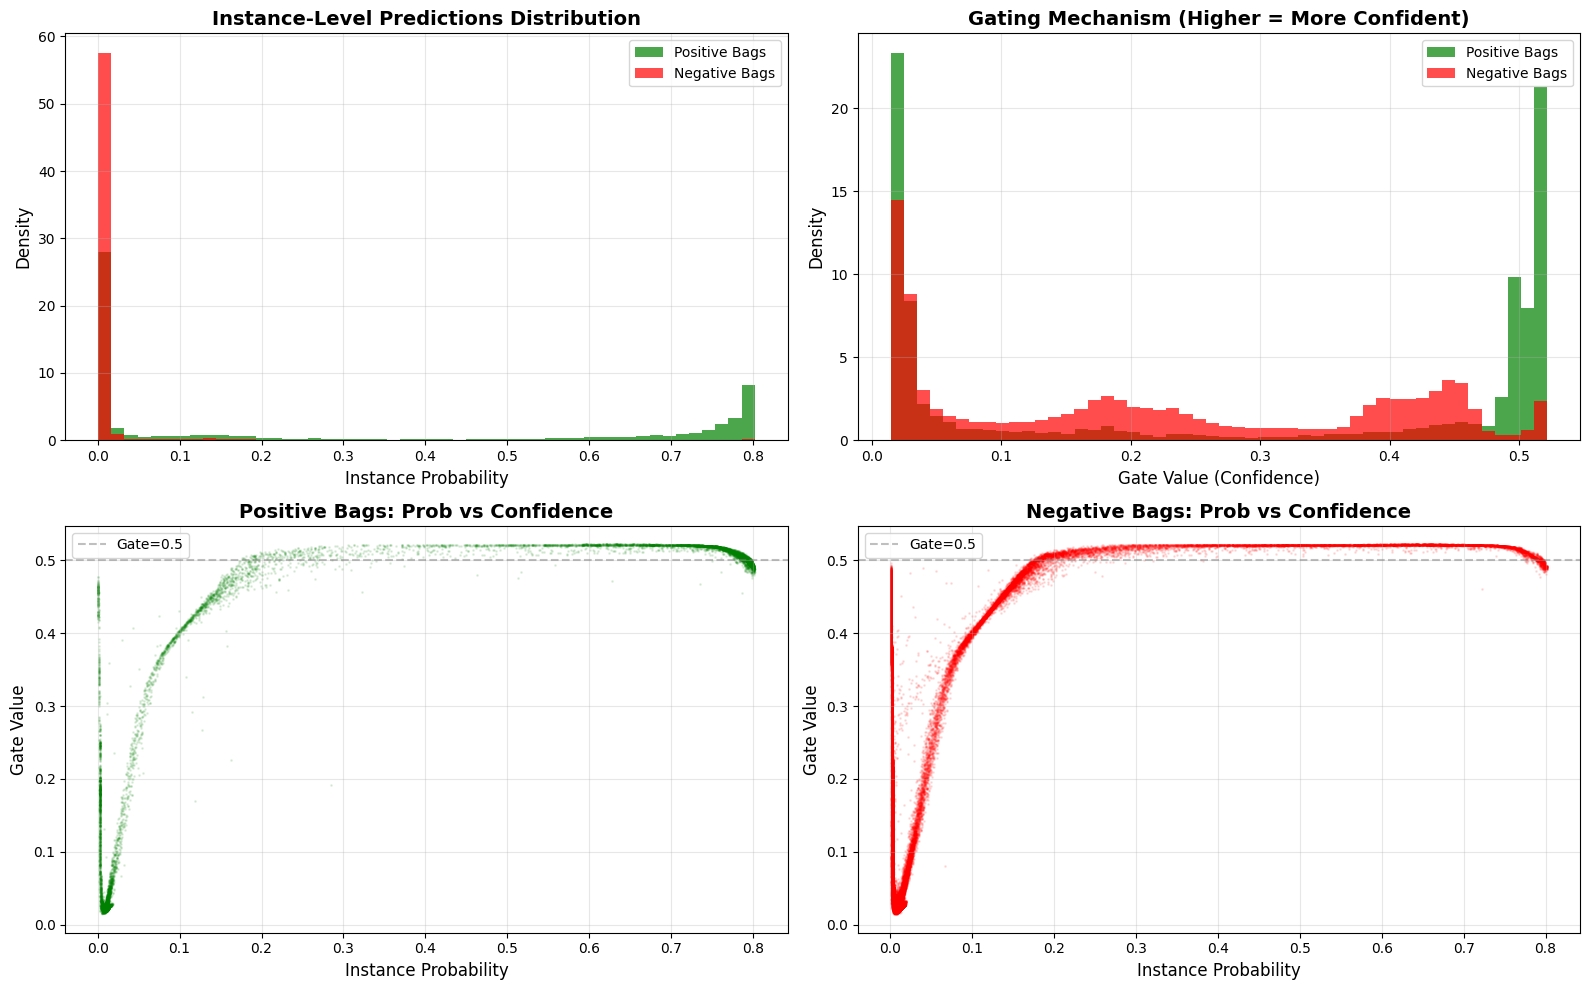


INSTANCE-LEVEL ANALYSIS (Noise Detection)

Positive Bags:
  Mean instance prob: 0.3035 (should be higher)
  Mean gate value: 0.2845
  High-confidence instances (gate > 0.5): 31.5%

Negative Bags:
  Mean instance prob: 0.0240 (should be lower)
  Mean gate value: 0.2199
  High-confidence instances (gate > 0.5): 3.0%

Separation:
  Instance prob difference: 0.2795 (higher is better)
  Gate value difference: 0.0646

WHAT TO LOOK FOR:
✓ Instance probabilities should separate well (positive > negative)
✓ Gates identify confident instances (high) vs noisy ones (low)
✓ Scatter plots show if model learns meaningful instance-level patterns
✓ Low gates = model suppressing those instances (likely noise)


In [13]:
# Analyze instance-level predictions to verify noise handling
model.eval()

instance_stats = {
    'positive_bags': {'instance_probs': [], 'gates': [], 'attention': []},
    'negative_bags': {'instance_probs': [], 'gates': [], 'attention': []}
}

with torch.no_grad():
    for x_num, x_seq, mask, y in tqdm(test_loader, desc="Analyzing instance-level predictions"):
        x_num = x_num.to(device)
        x_seq = x_seq.to(device)
        mask = mask.to(device)
        y = y.to(device)
        
        bag_logits, attn_weights, inst_logits, gates = model(x_num=x_num, x_seq=x_seq, mask=mask)
        inst_probs = torch.sigmoid(inst_logits)
        
        # Separate by bag label
        for i in range(len(y)):
            if mask[i].sum() > 0:
                valid_idx = mask[i] > 0
                key = 'positive_bags' if y[i] == 1 else 'negative_bags'
                
                instance_stats[key]['instance_probs'].extend(inst_probs[i][valid_idx].cpu().numpy())
                instance_stats[key]['gates'].extend(gates[i][valid_idx].cpu().numpy())
                instance_stats[key]['attention'].extend(attn_weights[i][valid_idx].cpu().numpy())

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Instance probabilities
axes[0, 0].hist(instance_stats['positive_bags']['instance_probs'], bins=50, alpha=0.7, 
                label='Positive Bags', color='green', density=True)
axes[0, 0].hist(instance_stats['negative_bags']['instance_probs'], bins=50, alpha=0.7, 
                label='Negative Bags', color='red', density=True)
axes[0, 0].set_xlabel('Instance Probability', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Instance-Level Predictions Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gate values (noise suppression mechanism)
axes[0, 1].hist(instance_stats['positive_bags']['gates'], bins=50, alpha=0.7, 
                label='Positive Bags', color='green', density=True)
axes[0, 1].hist(instance_stats['negative_bags']['gates'], bins=50, alpha=0.7, 
                label='Negative Bags', color='red', density=True)
axes[0, 1].set_xlabel('Gate Value (Confidence)', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].set_title('Gating Mechanism (Higher = More Confident)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter: Instance Prob vs Gate (Positive bags)
pos_probs = np.array(instance_stats['positive_bags']['instance_probs'])
pos_gates = np.array(instance_stats['positive_bags']['gates'])
axes[1, 0].scatter(pos_probs, pos_gates, alpha=0.1, s=1, c='green')
axes[1, 0].set_xlabel('Instance Probability', fontsize=12)
axes[1, 0].set_ylabel('Gate Value', fontsize=12)
axes[1, 0].set_title('Positive Bags: Prob vs Confidence', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Gate=0.5')
axes[1, 0].legend()

# Scatter: Instance Prob vs Gate (Negative bags)
neg_probs = np.array(instance_stats['negative_bags']['instance_probs'])
neg_gates = np.array(instance_stats['negative_bags']['gates'])
axes[1, 1].scatter(neg_probs, neg_gates, alpha=0.1, s=1, c='red')
axes[1, 1].set_xlabel('Instance Probability', fontsize=12)
axes[1, 1].set_ylabel('Gate Value', fontsize=12)
axes[1, 1].set_title('Negative Bags: Prob vs Confidence', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Gate=0.5')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "="*80)
print("INSTANCE-LEVEL ANALYSIS (Noise Detection)")
print("="*80)
print(f"\nPositive Bags:")
print(f"  Mean instance prob: {np.mean(pos_probs):.4f} (should be higher)")
print(f"  Mean gate value: {np.mean(pos_gates):.4f}")
print(f"  High-confidence instances (gate > 0.5): {(pos_gates > 0.5).mean()*100:.1f}%")

print(f"\nNegative Bags:")
print(f"  Mean instance prob: {np.mean(neg_probs):.4f} (should be lower)")
print(f"  Mean gate value: {np.mean(neg_gates):.4f}")
print(f"  High-confidence instances (gate > 0.5): {(neg_gates > 0.5).mean()*100:.1f}%")

print(f"\nSeparation:")
print(f"  Instance prob difference: {np.mean(pos_probs) - np.mean(neg_probs):.4f} (higher is better)")
print(f"  Gate value difference: {np.mean(pos_gates) - np.mean(neg_gates):.4f}")

print("\n" + "="*80)
print("WHAT TO LOOK FOR:")
print("="*80)
print("✓ Instance probabilities should separate well (positive > negative)")
print("✓ Gates identify confident instances (high) vs noisy ones (low)")
print("✓ Scatter plots show if model learns meaningful instance-level patterns")
print("✓ Low gates = model suppressing those instances (likely noise)")
print("="*80)

Gathering gate stats: 100%|██████████| 399/399 [00:17<00:00, 23.35it/s]


Instances collected: 255200
Class 0 — n=243400 — mean_gate=0.2199 — std=0.1668 — frac>0.5=0.030
Class 1 — n=11800 — mean_gate=0.2845 — std=0.2240 — frac>0.5=0.315

Correlation between gate and instance probability (per-instance):
corr = 0.37365317466609893


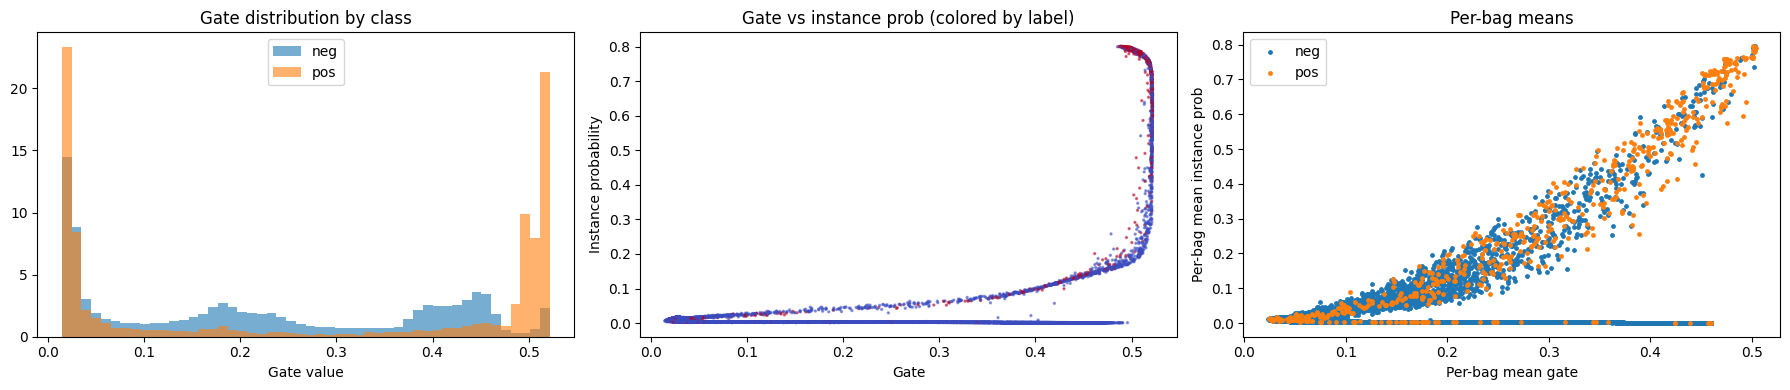


Suggested ablations:
 - Re-run with MILLoss(beta=0) to remove negative-instance penalty and compare gate histograms.
 - Temporarily set model.instance_dropout = 0 and re-evaluate to check dropout influence.
 - Inspect gate pre-activations by modifying GatedAttentionPooling.gate to return pre_sigmoid for diagnostics (advanced).


In [14]:
# Gate diagnostics: histograms, scatter, per-bag summaries
model.eval()
all_gates = []
all_probs = []
all_labels = []
per_bag_mean_gate = []
per_bag_mean_prob = []
per_bag_label = []

with torch.no_grad():
    for x_num, x_seq, mask, y in tqdm(test_loader, desc='Gathering gate stats'):
        x_num = x_num.to(device); x_seq = x_seq.to(device); mask = mask.to(device); y = y.to(device)
        _, _, inst_logits, gates = model(x_num=x_num, x_seq=x_seq, mask=mask)
        inst_probs = torch.sigmoid(inst_logits)
        # iterate bags in batch
        for i in range(len(y)):
            valid = (mask[i] > 0)
            if valid.sum() == 0:
                continue
            g = gates[i][valid].cpu().numpy()
            p = inst_probs[i][valid].cpu().numpy()
            lbl = int(y[i].item())
            all_gates.append(g)
            all_probs.append(p)
            all_labels.append(np.array([lbl] * len(g)))
            per_bag_mean_gate.append(g.mean())
            per_bag_mean_prob.append(p.mean())
            per_bag_label.append(lbl)

# Flatten per-instance arrays
g_flat = np.concatenate(all_gates) if len(all_gates) > 0 else np.array([])
p_flat = np.concatenate(all_probs) if len(all_probs) > 0 else np.array([])
lbl_flat = np.concatenate(all_labels) if len(all_labels) > 0 else np.array([])

print('Instances collected:', len(g_flat))
if len(g_flat) == 0:
    print('No valid instances found (check mask/bag_size).')

# Basic stats by class
for cls in (0, 1):
    sel = (lbl_flat == cls)
    if sel.sum() == 0:
        print(f'Class {cls}: no instances')
        continue
    vals = g_flat[sel]
    print(f'Class {cls} — n={len(vals)} — mean_gate={vals.mean():.4f} — std={vals.std():.4f} — frac>0.5={(vals>0.5).mean():.3f}')

print('\nCorrelation between gate and instance probability (per-instance):')
if len(g_flat) > 10:
    print('corr =', np.corrcoef(g_flat, p_flat)[0,1])

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Histogram of gates per class
axes[0].hist(g_flat[lbl_flat == 0], bins=50, alpha=0.6, label='neg', density=True)
axes[0].hist(g_flat[lbl_flat == 1], bins=50, alpha=0.6, label='pos', density=True)
axes[0].set_title('Gate distribution by class')
axes[0].set_xlabel('Gate value')
axes[0].legend()

# Scatter gate vs instance prob (subsample for plotting if huge)
N = len(g_flat)
idx = np.arange(N)
if N > 20000:
    rng = np.random.default_rng(0)
    idx = rng.choice(idx, size=20000, replace=False)
axes[1].scatter(g_flat[idx], p_flat[idx], c=lbl_flat[idx], s=2, cmap='coolwarm', alpha=0.5)
axes[1].set_xlabel('Gate')
axes[1].set_ylabel('Instance probability')
axes[1].set_title('Gate vs instance prob (colored by label)')

# Per-bag mean gate vs mean inst prob
per_bag_mean_gate = np.array(per_bag_mean_gate)
per_bag_mean_prob = np.array(per_bag_mean_prob)
per_bag_label = np.array(per_bag_label)
axes[2].scatter(per_bag_mean_gate[per_bag_label==0], per_bag_mean_prob[per_bag_label==0], s=6, label='neg')
axes[2].scatter(per_bag_mean_gate[per_bag_label==1], per_bag_mean_prob[per_bag_label==1], s=6, label='pos')
axes[2].set_xlabel('Per-bag mean gate')
axes[2].set_ylabel('Per-bag mean instance prob')
axes[2].set_title('Per-bag means')
axes[2].legend()

plt.tight_layout()
plt.show()

# Optional quick ablations to try (uncomment to run):
print('\nSuggested ablations:')
print(' - Re-run with MILLoss(beta=0) to remove negative-instance penalty and compare gate histograms.')
print(' - Temporarily set model.instance_dropout = 0 and re-evaluate to check dropout influence.')
print(' - Inspect gate pre-activations by modifying GatedAttentionPooling.gate to return pre_sigmoid for diagnostics (advanced).')

Collected 11975 validation bags, 14 numeric features
Baseline validation ROC-AUC: 0.9056
Valid instance positions in val set: 239500
Baseline validation ROC-AUC: 0.9056
Valid instance positions in val set: 239500
Feature 0: mean AUC drop = 0.0010
Feature 0: mean AUC drop = 0.0010
Feature 1: mean AUC drop = 0.0078
Feature 1: mean AUC drop = 0.0078
Feature 2: mean AUC drop = 0.0120
Feature 2: mean AUC drop = 0.0120
Feature 3: mean AUC drop = 0.0034
Feature 3: mean AUC drop = 0.0034
Feature 4: mean AUC drop = 0.0169
Feature 4: mean AUC drop = 0.0169
Feature 5: mean AUC drop = 0.0663
Feature 5: mean AUC drop = 0.0663
Feature 6: mean AUC drop = 0.0003
Feature 6: mean AUC drop = 0.0003
Feature 7: mean AUC drop = -0.0010
Feature 7: mean AUC drop = -0.0010
Feature 8: mean AUC drop = 0.0809
Feature 8: mean AUC drop = 0.0809
Feature 9: mean AUC drop = 0.0118
Feature 9: mean AUC drop = 0.0118
Feature 10: mean AUC drop = 0.0305
Feature 10: mean AUC drop = 0.0305
Feature 11: mean AUC drop = 0.0006


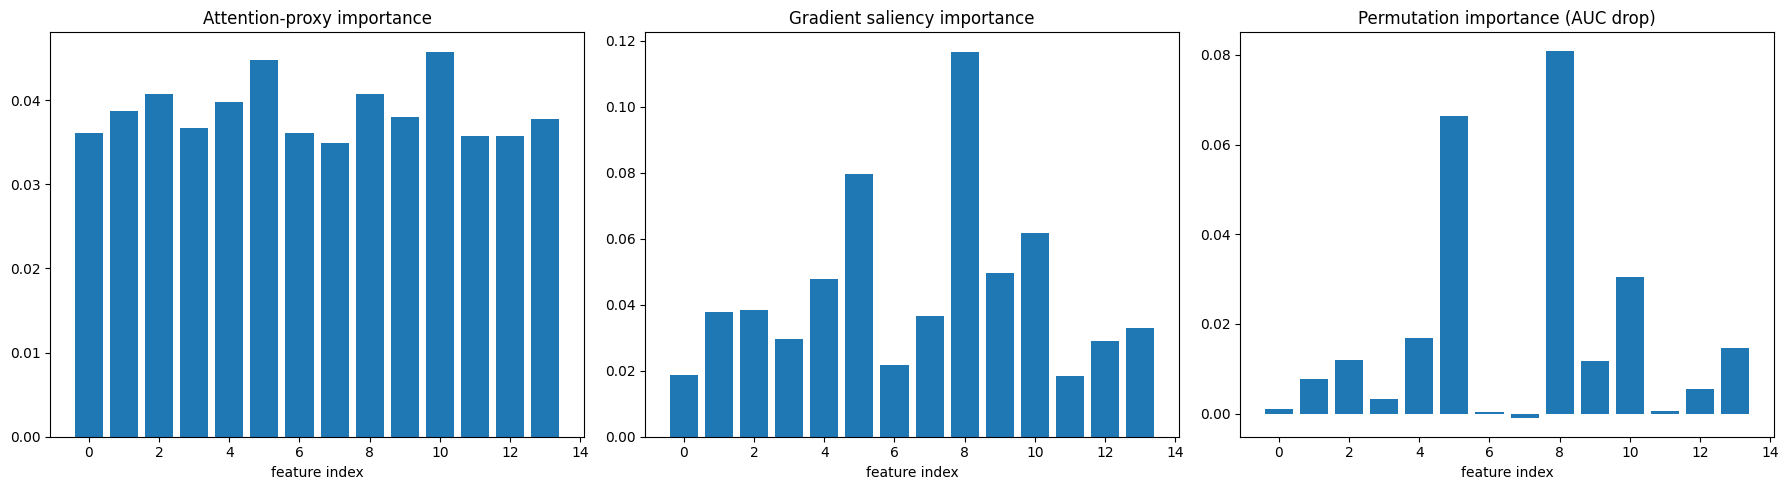


Top features by attention-proxy: [10  5  8  2  4]
Top features by grad saliency: [ 8  5 10  9  4]
Top features by permutation AUC-drop: [ 8  5 10  4 13]

Notes:
- Attention-proxy is fast but approximate (operates on learned representations).
- Gradient saliency gives a derivative-based signal; consider smoothing (IG) if noisy.
- Permutation importance directly measures metric impact; it is the most reliable but slow.


In [ ]:
# Feature importance diagnostics (attention proxy, gradient saliency, permutation importance)
model.eval()

# Quick helpers: collect validation data into arrays for offline work
val_x_nums = []
val_masks = []
val_ys = []

with torch.no_grad():
    for batch in val_loader:
        x_num, x_seq, mask, y = batch[:4]
        val_x_nums.append(x_num.cpu().numpy())
        val_masks.append(mask.cpu().numpy())
        val_ys.append(y.cpu().numpy())

if len(val_x_nums) == 0:
    print('No validation data found in val_loader; ensure val_loader is defined and has data')
else:
    val_x_nums = np.concatenate(val_x_nums, axis=0)  # [N_bags, K, F]
    val_masks = np.concatenate(val_masks, axis=0)
    val_ys = np.concatenate(val_ys, axis=0)
    N_bags, K, F = val_x_nums.shape
    print(f'Collected {N_bags} validation bags, {F} numeric features')

# 1) Attention-proxy importance
att_contribs = np.zeros(F, dtype=float)
att_counts = 0
with torch.no_grad():
    for batch in val_loader:
        x_num, x_seq, mask, y = batch[:4]
        x_num = x_num.to(device); x_seq = x_seq.to(device); mask = mask.to(device)
        bag_logits, attn_weights, inst_logits, gates = model(x_num=x_num, x_seq=x_seq, mask=mask)
        aw = attn_weights.detach().cpu().numpy()  # [B, K]
        xnum = x_num.detach().cpu().numpy()      # [B, K, F]
        m = mask.detach().cpu().numpy()
        B, Kb, Fb = xnum.shape
        for i in range(B):
            valid = m[i] > 0
            if valid.sum() == 0:
                continue
            contrib = (aw[i, valid][:, None] * np.abs(xnum[i, valid])).sum(axis=0)
            att_contribs += contrib
            att_counts += valid.sum()
att_importance = att_contribs / (att_counts + 1e-12)

# 2) Gradient saliency importance (may be slow)
grad_importance = np.zeros(F, dtype=float)
grad_counts = 0
for batch in val_loader:
    x_num, x_seq, mask, y = batch[:4]
    x_num = x_num.to(device)
    x_num.requires_grad_(True)
    x_seq = x_seq.to(device); mask = mask.to(device); y = y.to(device)
    out = model(x_num=x_num, x_seq=x_seq, mask=mask)
    bag_logits = out[0]
    B = bag_logits.shape[0]
    for i in range(B):
        model.zero_grad()
        if x_num.grad is not None:
            x_num.grad.zero_()
        bag_logits[i].backward(retain_graph=True)
        g = x_num.grad[i].detach().cpu().numpy()  # [K, F]
        m = mask[i].detach().cpu().numpy().astype(bool)
        if m.sum() == 0:
            continue
        feat_saliency = np.abs(g[m]).mean(axis=0)
        grad_importance += feat_saliency
        grad_counts += 1
    x_num.requires_grad_(False)
if grad_counts > 0:
    grad_importance = grad_importance / grad_counts

# 3) Permutation importance (AUC drop) - expensive; subsample if needed
baseline_probs = []
with torch.no_grad():
    for batch in val_loader:
        x_num, x_seq, mask, y = batch[:4]
        x_num = x_num.to(device); x_seq = x_seq.to(device); mask = mask.to(device)
        bag_logits = model(x_num=x_num, x_seq=x_seq, mask=mask)[0]
        baseline_probs.extend(torch.sigmoid(bag_logits).cpu().numpy())
baseline_probs = np.array(baseline_probs).ravel()
try:
    baseline_auc = roc_auc_score(np.concatenate([batch[3].cpu().numpy() for batch in val_loader]), baseline_probs)
except Exception:
    baseline_auc = np.nan
print(f'Baseline validation ROC-AUC: {baseline_auc:.4f}')

# Build list of valid positions for permutation
all_valid_positions = []
for i in range(N_bags):
    for k in range(K):
        if val_masks[i, k] > 0:
            all_valid_positions.append((i, k))
print(f'Valid instance positions in val set: {len(all_valid_positions)}')

def compute_auc_from_xnum(xnum_array):
    probs = []
    with torch.no_grad():
        idx = 0
        for batch in val_loader:
            B = batch[0].shape[0]
            xnum_batch = torch.tensor(xnum_array[idx:idx+B], dtype=torch.float32).to(device)
            xseq, mask = batch[1].to(device), batch[2].to(device)
            bag_logits = model(x_num=xnum_batch, x_seq=xseq, mask=mask)[0]
            probs.extend(torch.sigmoid(bag_logits).cpu().numpy())
            idx += B
    try:
        y_true = np.concatenate([batch[3].cpu().numpy() for batch in val_loader])
        return roc_auc_score(y_true, np.array(probs).ravel())
    except Exception:
        return np.nan

perm_importance = np.zeros(F, dtype=float)
n_perm = 4  # repeat count (reduced by default for speed)
for f in range(F):
    aucs = []
    for rep in range(n_perm):
        xnum_perm = val_x_nums.copy()
        flat_vals = [val_x_nums[i,k,f] for (i,k) in all_valid_positions]
        flat_vals = np.array(flat_vals)
        np.random.shuffle(flat_vals)
        for idx_pos, (i,k) in enumerate(all_valid_positions):
            xnum_perm[i, k, f] = flat_vals[idx_pos]
        auc = compute_auc_from_xnum(xnum_perm)
        aucs.append(auc)
    perm_importance[f] = baseline_auc - np.nanmean(aucs)
    print(f'Feature {f}: mean AUC drop = {perm_importance[f]:.4f}')

# Plot results
feat_idx = np.arange(F)
order_att = np.argsort(-att_importance)
order_grad = np.argsort(-grad_importance)
order_perm = np.argsort(-perm_importance)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].bar(feat_idx[order_att], att_importance[order_att])
axes[0].set_title('Attention-proxy importance')
axes[0].set_xlabel('feature index')

axes[1].bar(feat_idx[order_grad], grad_importance[order_grad])
axes[1].set_title('Gradient saliency importance')
axes[1].set_xlabel('feature index')

axes[2].bar(feat_idx[order_perm], perm_importance[order_perm])
axes[2].set_title('Permutation importance (AUC drop)')
axes[2].set_xlabel('feature index')

plt.tight_layout()
plt.show()

print('\nTop features by attention-proxy:', order_att[:5])
print('Top features by grad saliency:', order_grad[:5])
print('Top features by permutation AUC-drop:', order_perm[:5])

print('\nNotes:')
print('- Attention-proxy is fast but approximate (operates on learned representations).')
print('- Gradient saliency gives a derivative-based signal; consider smoothing (IG) if noisy.')
print('- Permutation importance directly measures metric impact; it is the most reliable but slow.')

## Feature importance for bag predictions

We'll compute three complementary measures of feature importance for the numeric features (the numeric `x_num` features available in `num_cols`):

1. Attention-based proxy (fast heuristic using attention weights)
2. Gradient saliency (per-bag gradients of the bag logit w.r.t. numeric inputs)
3. Permutation importance (direct AUC drop when a feature is shuffled)

Run the following cell to compute and visualize these analyses. Permutation importance is the slowest and can be subsampled if needed.

In [16]:
# Save test predictions
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)

# Use the DataFrame built in the prediction cell
if 'pred_df' in globals():
    results_df = pred_df.copy()
    # Normalize column names for downstream tools
    rename_map = {}
    if 'label' in results_df.columns:
        rename_map['label'] = 'true_label'
    if 'prob' in results_df.columns:
        rename_map['prob'] = 'predicted_probability'
    if rename_map:
        results_df = results_df.rename(columns=rename_map)
else:
    # Fallback if pred_df is not present, try to build from `results` dict
    assert 'results' in globals(), "No predictions found. Run the prediction cell first."
    results_df = pd.DataFrame(results)
    if 'label' in results_df.columns:
        results_df = results_df.rename(columns={'label': 'true_label'})
    if 'prob' in results_df.columns:
        results_df = results_df.rename(columns={'prob': 'predicted_probability'})

pred_path = output_dir / 'test_predictions.csv'
results_df.to_csv(pred_path, index=False)
print(f"Test predictions saved to {pred_path}")

# Save training history if available
if 'history_df' in globals():
    hist_path = output_dir / 'training_history.csv'
    history_df.to_csv(hist_path, index=False)
    print(f"Training history saved to {hist_path}")
else:
    print("Training history (history_df) not found; skip saving history.")

print(f"\nAll results saved to: {RUN_DIR}")

print("\n" + "="*80)
print("IMPROVEMENTS SUMMARY")
print("="*80)
print("\n🔧 Key Changes Made to Handle Noise:")
print("\n1. Stronger MIL Supervision (alpha: 0.3 → 1.0)")
print("   • 3.3x stronger instance-level learning")
print("   • Model learns which specific reads are informative vs noisy")
print("\n2. Negative Bag Instance Loss (NEW: beta=0.5)")
print("   • All instances in negative bags must have low probability")
print("   • Prevents false positives from noisy reads")
print("\n3. Gated Attention Pooling (NEW)")
print("   • Learns confidence 'gates' for each instance")
print("   • Low gate = noisy instance → suppressed")
print("   • High gate = informative instance → emphasized")
print("\n4. Instance Dropout (NEW: 15%)")
print("   • Randomly drops instances during training")
print("   • Improves robustness to missing/noisy reads")
print("\n5. Reduced Oversampling (10x → 3x)")
print("   • Less overfitting to noisy patterns in positive bags")
print("\n6. Deeper Instance Classifier")
print("   • Better discriminative capacity at instance level")
print("\n" + "="*80)
print("Expected Outcomes:")
print("="*80)
print("✓ Model should continue improving after first few epochs (not plateau)")
print("✓ Better instance-level discrimination between signal and noise")
print("✓ Validation metrics should be more stable and higher")
print("✓ Test performance should improve")
print("="*80)
print("\nTraining complete!")

Test predictions saved to ..\runs\run_20251029_105547\outputs\test_predictions.csv
Training history saved to ..\runs\run_20251029_105547\outputs\training_history.csv

All results saved to: ../runs/run_20251029_105547

IMPROVEMENTS SUMMARY

🔧 Key Changes Made to Handle Noise:

1. Stronger MIL Supervision (alpha: 0.3 → 1.0)
   • 3.3x stronger instance-level learning
   • Model learns which specific reads are informative vs noisy

2. Negative Bag Instance Loss (NEW: beta=0.5)
   • All instances in negative bags must have low probability
   • Prevents false positives from noisy reads

3. Gated Attention Pooling (NEW)
   • Learns confidence 'gates' for each instance
   • Low gate = noisy instance → suppressed
   • High gate = informative instance → emphasized

4. Instance Dropout (NEW: 15%)
   • Randomly drops instances during training
   • Improves robustness to missing/noisy reads

5. Reduced Oversampling (10x → 3x)
   • Less overfitting to noisy patterns in positive bags

6. Deeper Insta

In [17]:
# Save final trained model and a full checkpoint
save_dir = Path(CHECKPOINT_DIR)
save_dir.mkdir(parents=True, exist_ok=True)

# 1) Save just the model weights (preferred for loading with the same architecture)
final_state_path = save_dir / 'final_model_state_dict.pt'
torch.save(model.state_dict(), final_state_path)

# 2) Save a full checkpoint (model + optimizer + scaler + basic training config)
final_ckpt_path = save_dir / 'final_checkpoint.pt'
final_checkpoint = {
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    # Path to the saved feature StandardScaler (joblib) -- saved earlier if available
    'feature_scaler_path': str(save_dir / 'scaler.joblib') if ('scaler' in globals() and scaler is not None) else None,
    # AMP GradScaler state dict (for resuming mixed-precision training)
    'amp_scaler_state': amp_scaler.state_dict() if ('amp_scaler' in globals() and amp_scaler is not None) else None,
    'training': {
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'epochs': EPOCHS,
        'warmup_steps': WARMUP_STEPS,
    },
    'timestamp': TIMESTAMP,
}
torch.save(final_checkpoint, final_ckpt_path)
print(f"Saved model weights to {final_state_path}")
print(f"Saved full checkpoint to {final_ckpt_path}")

Saved model weights to ..\runs\run_20251029_105547\checkpoints\final_model_state_dict.pt
Saved full checkpoint to ..\runs\run_20251029_105547\checkpoints\final_checkpoint.pt
